In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-stsb-mean-tokens')

C:\Users\Savannah\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Savannah\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Savannah\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Savannah\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWa

# Response Matching

## Load survey data

In [2]:
# Read it in
path = "../data/surveys.xlsx"
survey_32W = pd.read_excel(path, sheet_name="Survey_32W", converters={'T3':str})

# Drop unnecessary columns
survey_32W.drop(columns=['Unnamed: 0', 'subject_id', 'image_name', 'image_name_2'], inplace=True)

# Drop rows missing response
survey_32W = survey_32W[
    (survey_32W['T3'] != ' ') &
    (survey_32W['T3'] != 'none') &
    (survey_32W['T3'].notnull()) &
    (survey_32W['T3'] != 'No Comments ') &
    (survey_32W['T3'] != 0) &
    (survey_32W['T3'] != 'None') &
    (survey_32W['T3'] != '[NO ANSWER]') &
    (survey_32W['T3'] != 'no comments') &
    (survey_32W['T3'] != 'no comments.') &
    (survey_32W['T3'] != '0') &
    (survey_32W['T3'] != 'none.') &
    (survey_32W['T3'] != '[none]') &
    (survey_32W['T3'] != 'no comment') &
    (survey_32W['T3'] != 'No comments were made') &
    (survey_32W['T3'] != 'No Reason') &
    (survey_32W['T3'] != 'No reason.')]

# Select responses
res_same_32W = survey_32W['T3'][survey_32W['T1'] == "['They should be together in the same outfits']"].tolist()
res_separate_32W = survey_32W['T3'][survey_32W['T1'] == "['They should be in separate outfits']"].tolist()
res_32W = res_same_32W + res_separate_32W

## Get embeddings

In [3]:
embed_same_32W = model.encode(res_same_32W)
embed_separate_32W = model.encode(res_separate_32W)
embed_32W = np.concatenate((embed_same_32W, embed_separate_32W), axis = 0)

## Compare responses

In [5]:
def compare_all(res, embed):
    distances = scipy.spatial.distance.cdist([embed], embed_32W, "cosine")[0]
    distances_sorted = sorted(zip(range(len(distances)), distances), key=lambda x: x[1])
    return {
        "response": res,
        "best_match": res_32W[distances_sorted[1][0]],
        "score": 1-distances_sorted[1][1]
    }

results = [compare_all(res, embed) for res, embed in zip(res_32W, embed_32W)]

## Write as CSV

In [6]:
# Convert list of results to dataframe
df = pd.DataFrame(results)
# Sort results by cosine similarity
df = df.sort_values('score', ascending=False)
# Write to csv
df.to_csv("../data/response_match.csv", index=False)

# Low-rank approximation?

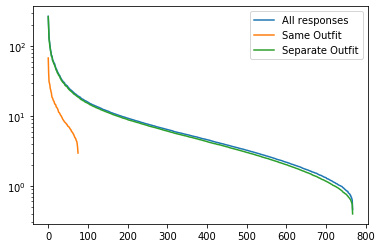

In [8]:
# Transpose so each column is an embedding
for A in [np.transpose(embed_32W), np.transpose(embed_same_32W), np.transpose(embed_separate_32W)]:
    U,S,Vt = np.linalg.svd(A, full_matrices=False)
    plt.semilogy(S)
plt.legend(["All responses", "Same Outfit", "Separate Outfit"])

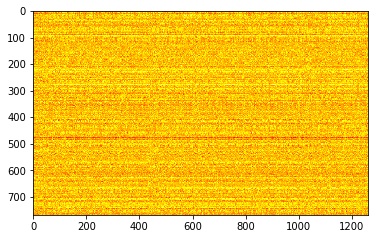

In [14]:
plt.imshow(np.transpose(embed_32W), cmap='hot', interpolation='nearest')
plt.show()

# (Approximately) distributive?

In [33]:
temp = [
    np.array(model.encode(["foo", "bar", "foo"+"bar"])),
    np.array(model.encode(["foo", "bar", "foo"+" "+"bar"])),
    np.array(model.encode(["Here's a short sentence.", "Is BERT distributive?", "Here's a short sentence."+"Is BERT distributive?"])),
    np.array(model.encode(["Here's a short sentence.", "Is BERT distributive?", "Here's a short sentence."+" "+"Is BERT distributive?"])),
    np.array(model.encode(["Here's a short sentence.", "Is BERT distributive?", "The fish swims in the pond."])),
    np.array(model.encode(["Here's a short sentence.", "Is BERT distributive?", "This sentence is short. Does BERT uphold the distributive property?"])),
    np.array(model.encode(["I will go to the store this afternoon.", "The tallest building in the world is the Burj Khalifa.", "I will go to the store this afternoon."+"The tallest building in the world is the Burj Khalifa."])),
    np.array(model.encode(["I will go to the store this afternoon.", "The tallest building in the world is the Burj Khalifa.", "I will go to the store this afternoon."+" "+"The tallest building in the world is the Burj Khalifa."]))
]

for t in temp:
    print(np.dot(t[0]+t[1], t[2]) / (np.linalg.norm(t[0]+t[1]) * np.linalg.norm(t[2])))

0.7797814
0.8732522
0.8964534
0.8964534
0.021588128
0.71422464
0.8697224
0.8697224
-0.09511029
